# Swyft in 15 Minutes

We discuss seven key steps of a typical Swyft workflow.

## 1. Installing Swyft

We can use `pip` to install the lightning branch (latest development branch) of Swyft.

In [33]:
#!pip install https://github.com/undark-lab/swyft.git@lightning

In [34]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

## 2. Define the Simulator

Next we define a simulator class, which specifies the computational graph of our simulator.

In [35]:
class Simulator(swyft.Simulator):
    def __init__(self):
        super().__init__()
        self.on_after_forward = swyft.to_numpy32
        self.x = np.linspace(-1, 1, 10)
         
    def forward(self, trace):
        z = trace.sample('z', lambda: np.random.rand(2)*2-1)
        f = trace.sample('f', lambda z: z[0] + z[1]*self.x, z)
        x = trace.sample('x', lambda f: f + np.random.randn(10)*0.1, f)
        
sim = Simulator()
samples = sim.sample(N = 10000)

100%|██████████| 10000/10000 [00:00<00:00, 25406.81it/s]


## 3. Define the SwyftModule

In [36]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Linear(10, 2)
        self.classifier = swyft.RatioEstimatorMLP1d(x_dim = 2, z_dim = 2)

    def forward(self, A, B):
        embedding = self.embedding(A['x'])
        ratios = self.classifier(embedding, B['z'])
        return dict(z = ratios)

## 4. Train the model

In [37]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [38]:
dl_train = samples[:-500].get_dataloader(batch_size = 64, shuffle = True)
dl_valid = samples[-500:].get_dataloader(batch_size = 64)

In [39]:
network = Network()
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | embedding  | Linear              | 22    
1 | classifier | RatioEstimatorMLP1d | 34.9 K
---------------------------------------------------
35.0 K    Trainable params
0         Non-trainable params
35.0 K    Total params
0.140     Total estimated model params size (MB)
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_9820992/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  95%|█████████▍| 149/157 [00:01<00:00, 85.01it/s, loss=-1.7, v_num=9820992] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  96%|█████████▌| 150/157 [00:01<00:00, 79.05it/s, loss=-1.82, v_num=9820992, val_loss=-1.79]
Validating: 0it [00:00, ?it/s]
Epoch 2:  95%|█████████▍| 149/157 [00:01<00:00, 87.06it/s, loss=-1.99, v_num=9820992, val_loss=-1.95]
Validating: 0it [00:00, ?it/s]
Epoch 3:  95%|█████████▍| 149/157 [00:01<00:00, 91.35it/s, loss=-1.95, v_num=9820992, val_loss=-2.01]
Validating: 0it [00:00, ?it/s]
Epoch 4:  95%|█████████▍| 149/157 [00:01<00:00, 85.02it/s, loss=-2.03, v_num=9820992, val_loss=-2.04]
Validating: 0it [00:00, ?it/s]
Epoch 5:  95%|█████████▍| 149/157 [00:01<00:00, 83.43it/s, loss=-2.06, v_num=9820992, val_loss=-2.08]
Validating: 0it [00:00, ?it/s]
Epoch 6:  95%|█████████▍| 149/157 [00:01<00:00, 89.94it/s, loss=-2.05, v_num=9820992, val_loss=-2.11]
Validating: 0it [00:00, ?it/s]
Epoch 7:  95%|█████████▍| 149/157 [00:01<00:00, 89.17it/s, loss=-2.08, v_num=9820992,

## 5. Visualize training

## 6. Perform validation tests

In [40]:
trainer.test(network, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': -2.078296661376953, 'hp/KL-div': -4.338498115539551}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 8/8 [00:00<00:00, 162.90it/s]


[{'hp/JS-div': -2.078296661376953, 'hp/KL-div': -4.338498115539551}]

In [42]:
B = samples[:1000]
A = samples[:1000]
mass = trainer.estimate_mass(network, A, B)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 149it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting: 100%|██████████| 1000/1000 [00:14<00:00, 58.00it/s]


## 7. Generate posteriors

In [99]:
x0 = sim.sample(conditions = {"z": np.array([-0.5, 0.5])})['x']

In [100]:
predictions = trainer.infer(network, swyft.Sample(x = x0), dl_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 100%|██████████| 149/149 [00:00<?, ?it/s]


In [101]:
posterior_samples = predictions.sample(100000)

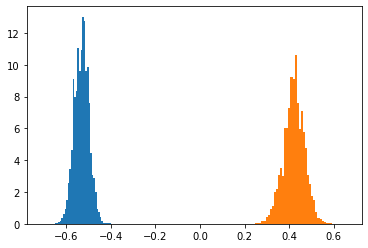

In [102]:
plt.hist(posterior_samples['z'][:,0].numpy(), bins = 50, density = True);
plt.hist(posterior_samples['z'][:,1].numpy(), bins = 50, density = True);